- RNN-GAN - fourier-transformed audiodata - split complex number values

In [1]:
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

Add path to util-functions

In [2]:
import sys
sys.path.append('D:/1. Studium/7. Semester/BA/Birdvoice/utils')

The Paths to the FT-databases

In [3]:
databasePathsParusMajor=['../../../../dataPreprocessing/databases/ft/parusMajor/ParusMajorSongFT1.csv', '../../../../dataPreprocessing/databases/ft/parusMajor/ParusMajorSongFT5.csv']
databasePathsTurdusMerula=['../../../../dataPreprocessing/databases/ft/turdusMerula/TurdusMerulaSongFT5.csv']
databasePathsCorvusCorone=['../../../../dataPreprocessing/databases/ft/corvusCorone/CorvusCoroneCallFT5.csv']

Load data from chosen path

In [4]:
readSampleCount = 500

#number of columns per dataset-sample for
ONE_SECOND = 22
FIVE_SECONDS = 108

#load and reshape data
x_train = pd.read_csv(databasePathsTurdusMerula[0], header=None, delimiter=',', index_col=None, nrows=readSampleCount).to_numpy()
x_train = np.reshape(x_train, [readSampleCount, 1025, FIVE_SECONDS])
print(x_train)

#change datatype to complex128 and expand one dim
x_train = x_train.astype('complex128')

SAMPLE_COUNT, AUDIO_ROWS, AUDIO_COLS = x_train.shape

[[['(-0.014772154+0j)' '(-0.0073714806+0j)' '(6.789393e-05+0j)' ...
   '(-0.00012515683+0j)' '(0.00028530793+0j)' '(0.006124617+0j)']
  ['(0.01472751-2.4733362e-18j)' '(4.2481588e-05+0.0074026017j)'
   '(-5.7866713e-05+3.6582183e-05j)' ...
   '(1.9505971e-05-0.00016416561j)' '(0.00073923275+0.00028742355j)'
   '(-0.0031299691+0.0055543547j)']
  ['(-0.01462455+2.99936e-18j)' '(0.0072760386-6.0696326e-05j)'
   '(2.1559532e-05+4.351068e-05j)' ... '(2.3055427e-05+7.0379814e-05j)'
   '(0.00011017384+0.0005063219j)' '(-0.0030036345-0.0055081j)']
  ...
  ['(6.613875e-05-1.3730567e-18j)' '(-4.590701e-05+6.8263744e-06j)'
   '(1.11812105e-05-2.2286069e-05j)' ... '(-5.023377e-06-3.816736e-06j)'
   '(1.630423e-05-3.9252092e-05j)' '(-0.00019118945+0.00035524156j)']
  ['(-5.9319264e-05+1.1587411e-18j)' '(1.9876964e-06+2.1362228e-05j)'
   '(-6.3429875e-06+3.6729007e-06j)' ...
   '(-9.604153e-08+1.1872922e-06j)' '(3.3583612e-05-2.0382422e-05j)'
   '(-0.00020787139-0.000354218j)']
  ['(5.402969e-05+0j)

TODO: replace value and insert imaginary part after that

In [5]:
combinedArray = np.empty((readSampleCount, 1025, AUDIO_COLS*2), dtype=np.float32)

#split the compiles data for all numbers
for lineIndex in range(SAMPLE_COUNT):
    for rowIndex in range(AUDIO_ROWS):
        for colIndex in range(AUDIO_COLS):
            combinedArray[lineIndex][rowIndex][colIndex*2] = x_train[lineIndex][rowIndex][colIndex].real
            combinedArray[lineIndex][rowIndex][colIndex*2+1] = x_train[lineIndex][rowIndex][colIndex].imag

In [6]:
x_train = combinedArray.copy()
SAMPLE_COUNT, AUDIO_ROWS, AUDIO_COMBINED = x_train.shape

Create optimizer

In [7]:
optimiser = keras.optimizers.Adam(0.002, 0.5)

Create the discriminator

In [8]:
from utils.discriminatorsFT import *

In [9]:
discriminator = buildDiscriminator1(AUDIO_ROWS, AUDIO_COMBINED)
discriminator.compile(loss = "binary_crossentropy",
                      optimizer = optimiser,
                      metrics = "accuracy")

Create the generator and GAN

In [10]:
from utils.generatorsFT import *

In [11]:
generator = buildGenerator4(AUDIO_ROWS, AUDIO_COMBINED)

print(discriminator.trainable)
discriminator.trainable = False
gan = keras.models.Sequential( [generator, discriminator] )
gan.compile(loss="binary_crossentropy",
           optimizer = optimiser,
           metrics = "accuracy")


True


Run the training:

In [12]:
from utils.trainingFT import trainFT

In [13]:
ITERATIONS = 10
BATCH_SIZE = 1

trainFT(iterations=ITERATIONS, batch_size=BATCH_SIZE, generator=generator, discriminator=discriminator, network=gan, data=x_train, columnCount=AUDIO_COMBINED)

print("Generator:")
generator.summary()
print("Discriminator:")
discriminator.summary()
print("GAN:")
gan.summary()

Iteration: 0
1/1 [==============================] - 5s 5s/step
d_loss_real: {'loss': 0.709528386592865, 'accuracy': 0.0039024390280246735}
d_loss_gen: {'loss': 0.696527898311615, 'accuracy': 0.0009756097570061684}
g_loss: [0.6914082765579224, 0.00585365854203701]
Iteration: 1
1/1 [==============================] - 5s 5s/step
d_loss_real: {'loss': 0.6918426156044006, 'accuracy': 0.0009756097570061684}
d_loss_gen: {'loss': 0.700383186340332, 'accuracy': 0.0019512195140123367}
g_loss: [0.6932994723320007, 0.0]
Iteration: 2
1/1 [==============================] - 5s 5s/step
d_loss_real: {'loss': 0.695877194404602, 'accuracy': 0.007804878056049347}
d_loss_gen: {'loss': 0.7016019821166992, 'accuracy': 0.0}
g_loss: [0.6935982704162598, 0.0]
Iteration: 3
1/1 [==============================] - 5s 5s/step
d_loss_real: {'loss': 0.6934005618095398, 'accuracy': 0.007804878056049347}
d_loss_gen: {'loss': 0.7108813524246216, 'accuracy': 0.0}
g_loss: [0.7022660970687866, 0.0]
Iteration: 4
1/1 [========

Test of generator after training

1/1 [==============================] - 5s 5s/step


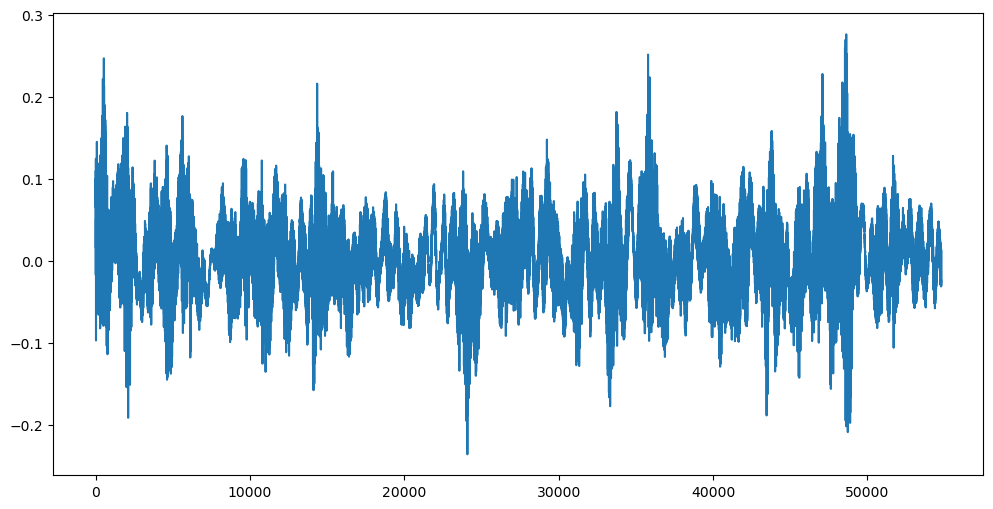

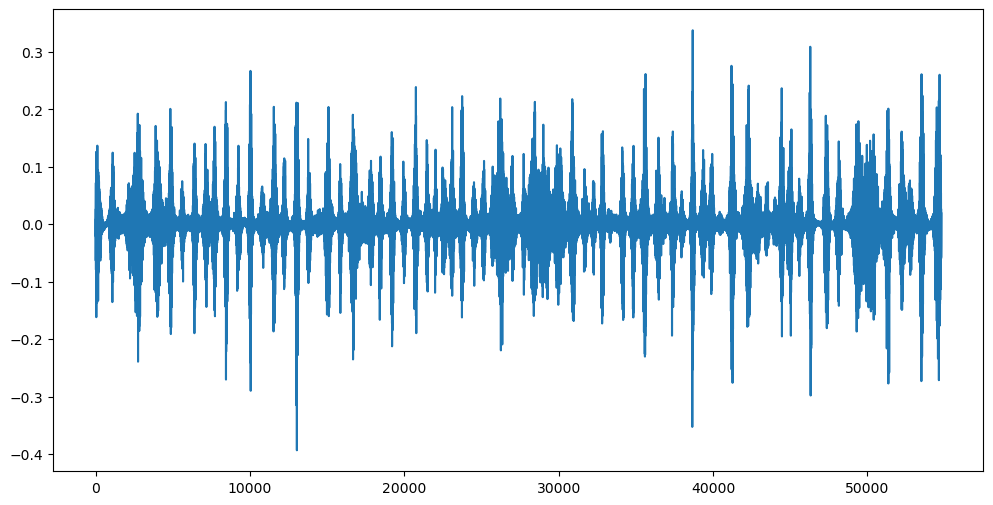

In [14]:
#generate sound
noise = np.random.normal(0,0.01, (1, 1025, AUDIO_COMBINED))  
fake_audios = generator.predict(noise)

#combine split to complex values
complexDataArray = np.empty((1, 1025, AUDIO_COLS), dtype=np.complex128)
for lineIndex in range(complexDataArray.shape[0]):
    for rowIndex in range(complexDataArray.shape[1]):
        for colIndex in range(complexDataArray.shape[2]):
            complexDataArray[lineIndex][rowIndex][colIndex] = complex(fake_audios[lineIndex][rowIndex][colIndex*2], fake_audios[lineIndex][rowIndex][colIndex*2+1])

istftAudio = librosa.istft(complexDataArray[0])
glAudio = librosa.griffinlim(complexDataArray[0])

#show
plt.figure(figsize=(12, 6))
plt.plot(istftAudio*100)

plt.figure(figsize=(12, 6))
plt.plot(glAudio)

Save generated output to file

In [15]:
sf.write("tm5g4d1gen.wav", istftAudio*100, 11025)
sf.write("tm5g4d1gl.wav", glAudio, 11025)